# G2: 프로젝트: ResNet Ablation Study

#### 루브릭
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?   
: 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?   
: cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?   
: ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

## Dataset

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# other libraries
import urllib3
urllib3.disable_warnings()

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [4]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


## Normalize Dataset

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_info.features["label"].num_classes

2

In [8]:
ds_info.features["label"].names

['cat', 'dog']

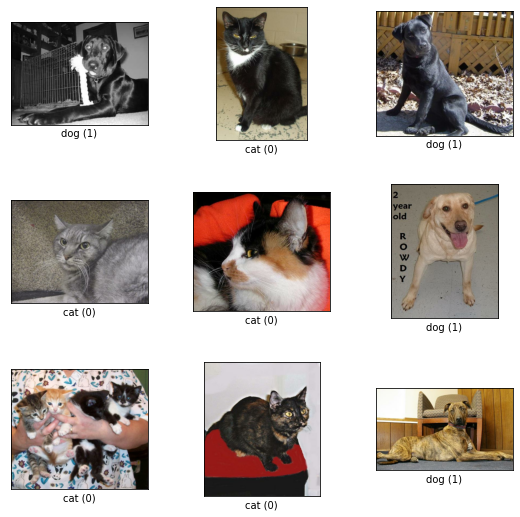

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

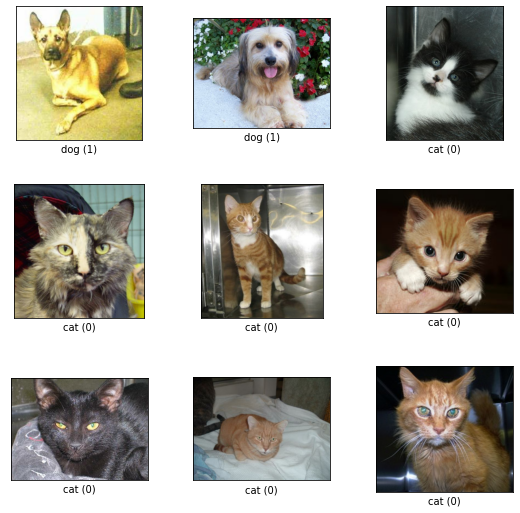

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

## 1) ResNet 기본 블록 구성하기

### ResNet 블록 for Res34
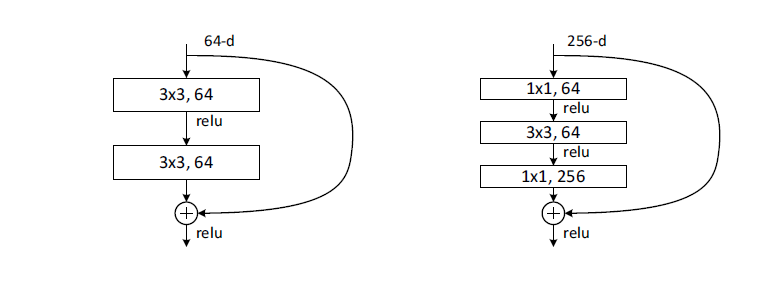
- ResNet 블록을 굳이 왜 두 가지로 나누었을까?
- 위 그림에서 보면, 왼쪽 ResNet 블록(Identity block)은 입력 차원과 출력 차원을 유지시킨다. 그러나, 입력 차원으로 부터 결국에는 두 개의 class로 분류 가능하도록 하기 위해 차원을 줄이는 블록이 필요하다. 
- 따라서, 오른쪽 ResNet 블록(Bottleneck block)은 첫번째 3 * 3 convolution layer에서 stride=2, pooling = 1로 설정하여 출력 차원= 입력차원 * 0.5로 만들어준다. 따라서 차원을 맞춰주기 위해 skip connection에서 1 * 1 convolutional layer의 stride = 2로 설정한다.

### ResNet 블록 for Res50
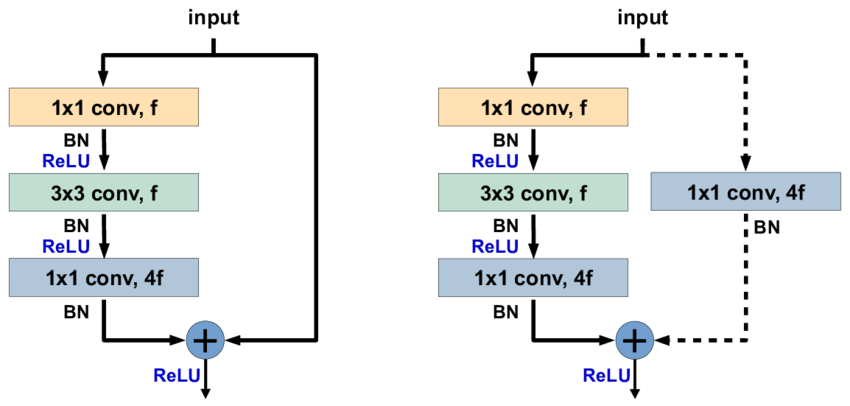
- 왜 더 깊은 layer를 쌓을 때 1 * 1 convolutional layer를 추가해서 기본 블록을 바꿀까?   
: 설명하기 위해 아래 그림을 보자.
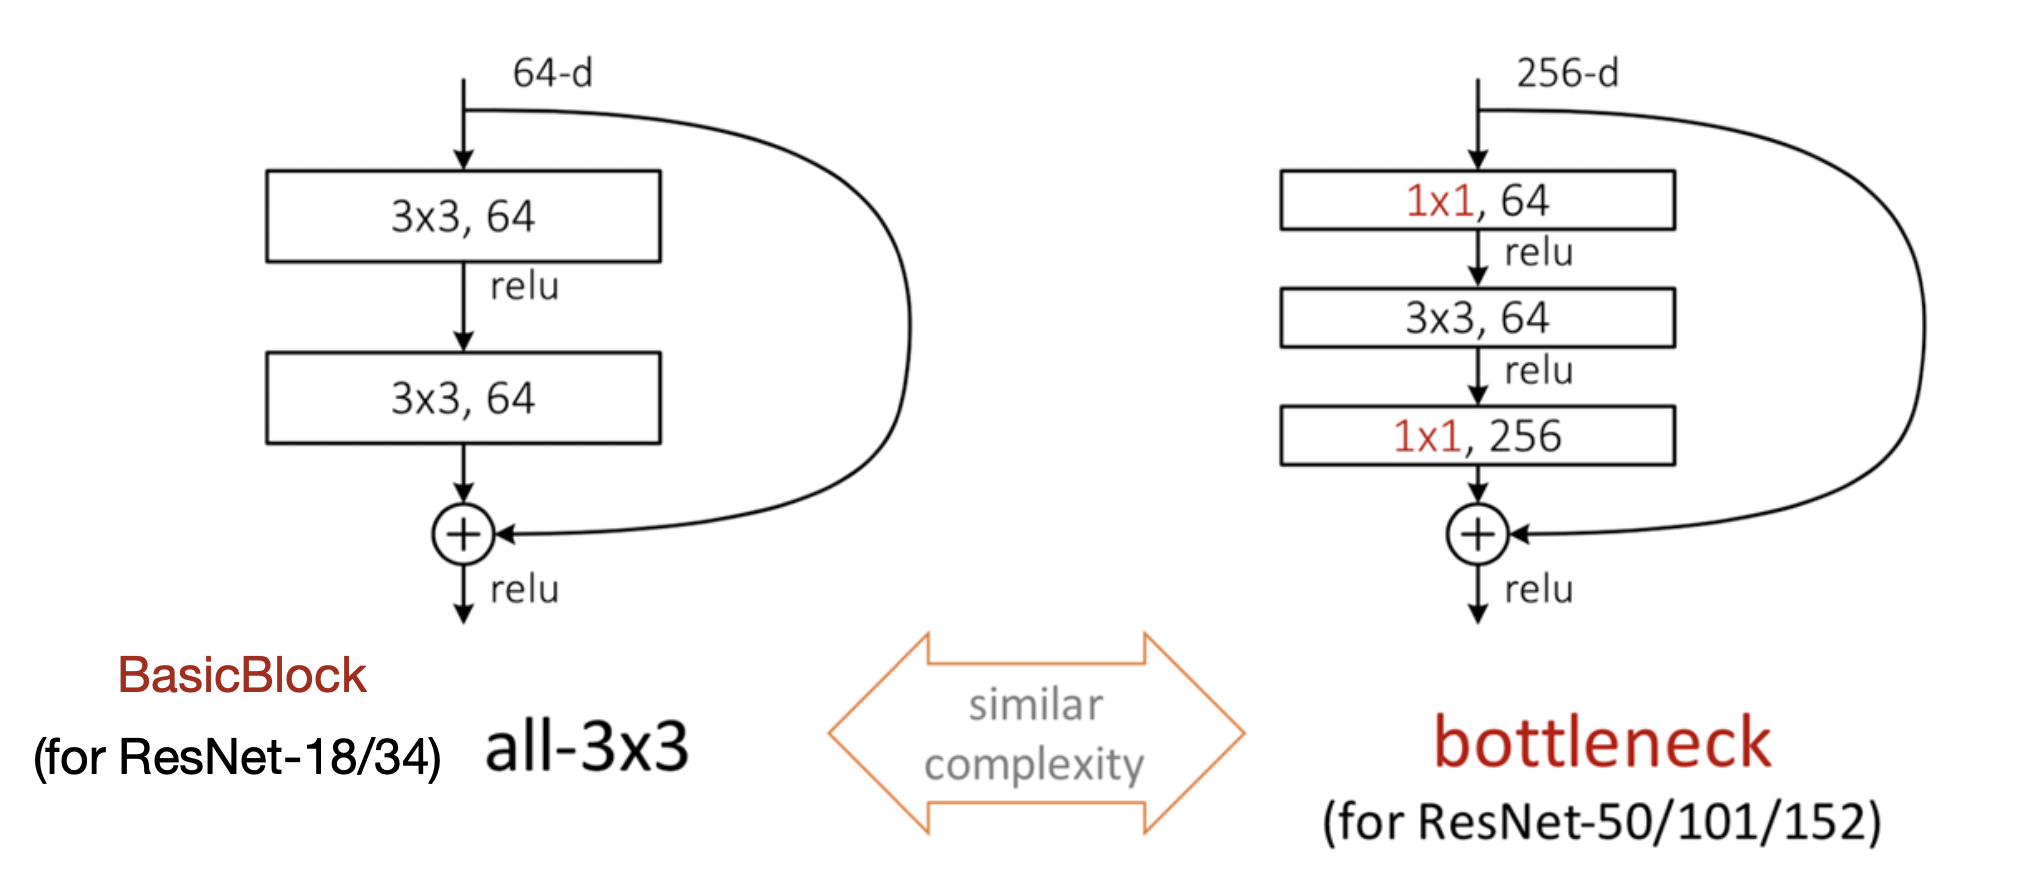
- 왼쪽 그림(기존 블록)에선 3 * 3 convolutional layer가 64개의 filter를 통과한다. 이 부분을 유지한 채, 오른쪽과 같이 3 * 3 convolutional layer 전후에 1 * 1 convolutional layer를 쌓아 Encoding, Decoding 원리를 사용하도록 한다. 풀어서 설명하면, 입력 필터를 4배로 많이 넣어준 후, 1 * 1 convolutional layer로 encoding 시킨다. 그 후 3 * 3 convolutional layer를 통과하고 마지막으로 1 * 1 convolutional layer로 decoding해서 변수의 수를 4배로 복원시키는 것이다. 결국 input filter를 4배 많이 사용할 수 있다는 것이다. 이것이 왜 중요하냐? filter는 하나의 특징을 잡아주는 역할을 하는데 layer가 깊어질수록 특징들을 보존하는 데에 어려움이 있을 것으로 추측해본다. 따라서 많은 특징들을 잡아주면 깊은 layer를 통과해도 더 많은 특징들이 남게 되어 모델의 성능이 좋아질 것이다.
- 또 다른 이점은 연산의 효율성이다. 연산이 효율적이기 위해선 weight 파라미터의 수가 적어야 한다.
- convolutional layer weight 개수 = input filter size * filter size * output filter size
- 왼쪽 블록: 64 * (3 * 3) * 64 + 64 * 3 * 3 * 64 = 73,728
- 오른쪽 블록: 256 * 1 * 1 * 64 + 64 * 3 * 3 * 64 + 64 * 1 * 1 * 256 = 69,632
- 왼쪽 블록 parameter > 오른쪽 블록 parameter

### Convolutional Block
- 모델의 구조를 보면 Convolutional layer- Batch Normalization - Relu Activation layer가 반복된다.
- 이 점에 착안해서 세개의 layer를 하나로 묶어주는 함수를 사용한다면 훨씬 코드가 간결해진다.

In [11]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1,          
               activation='relu'):
# convolutional layer    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)

# Batch Normalization
    x = keras.layers.BatchNormalization()(x)

# Relu Activation layer
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

### ResNet block, Plain block
- ResNet 50 블록
- ResNet 34 블록
- Plain-50 블록
- Plain-34 블록

In [12]:
def build_resnet_or_plain_block(input_shape, 
                                num_cnn=3, 
                                channel=64, 
                                block_num=0,
                                is_50 = True,
                                is_skip_connection = True):
   
    x = input_shape
    
    # ResNet-50(skip connection 존재)
    if is_50 and is_skip_connection:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34(skip connection 존재)
    elif not is_50 and is_skip_connection :
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
            
    # Plain-50(skip connection 없음)
    elif is_50 and not is_skip_connection:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
                
    # Plain-34(skip connection 없음)
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))
            

    return x

### 모델 생성 함수
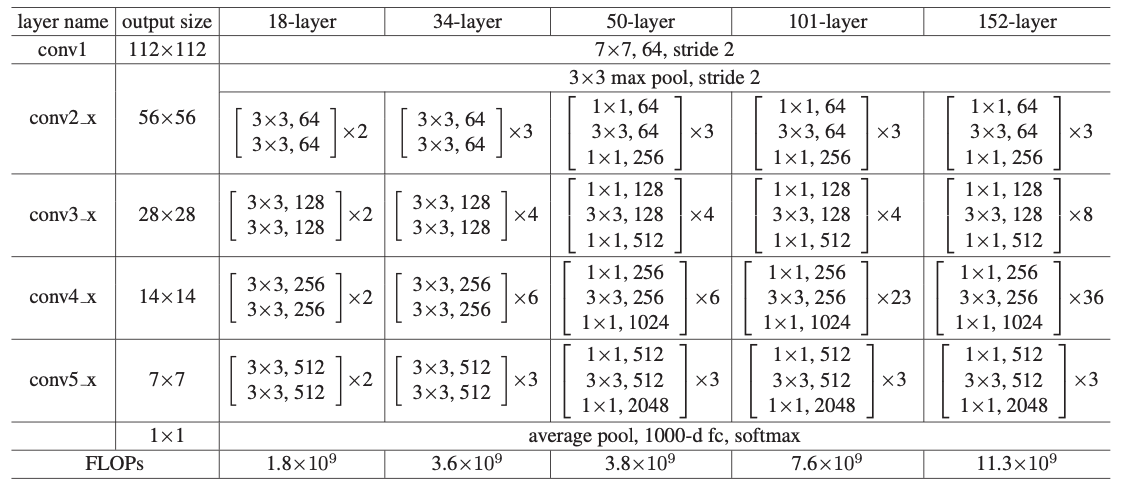
#### ResNet(PlainNet 기능 추가) 생성 함수
- 위의 그림을 보고 구조를 리스트를 통해 구현해본다.
- (3 * 3, 64), (3 * 3, 128), (3 * 3, 256), (3 * 3, 512) 부분이 두 개씩 반복되므로 num_cnn_34_list = [2,2,2,2]
- ResNet 블록 for 50의 기본 블록은 3 * 3 convolutional layer가 반복되지 않으므로 num_cnn_50_list = [1,1,1,1]
- 필터의 수를 ResNet 34, ResNet 50 각각 channel_34_list, channel_50_list에 저장한다.
- 한 블록의 반복횟수를 num_block_stack_list에 저장한다. 이 부분은 ResNet 34, ResNet50 동일하다.

In [13]:
# ResNet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
                 num_cnn_34_list=[2,2,2,2],
                 num_cnn_50_list = [1,1,1,1],
                 channel_34_list=[64,128,256,512],
                 channel_50_list = [256,512,1024,2048],
                 num_block_stack_list = [3,4,6,3],
                 num_classes=2, 
                 is_50=True, 
                 is_skip_connection = True,
                 activation='softmax',
                 name = 'ResNet-50'):
    
    assert len(num_block_stack_list) == len(channel_34_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    assert len(num_block_stack_list) == len(channel_50_list)
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # ResNet 34와 ResNet 50의 공통된 앞 부분
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual 블록을 생성합니다.
    # ResNet 50의 Residual 블록
    if is_50 and is_skip_connection:
        for block_num, (num_cnn_50, channel_50) in enumerate(zip(num_cnn_50_list, channel_50_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_50, 
                               channel=channel_50, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)
            
    # ResNet 34의 Residual 블록
    elif not is_50 and is_skip_connection:
        for block_num, (num_cnn_34, channel_34) in enumerate(zip(num_cnn_34_list, channel_34_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_34, 
                               channel=channel_34, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)
            
    # Plain 50의 블록
    elif is_50 and not is_skip_connection:
        for block_num, (num_cnn_50, channel_50) in enumerate(zip(num_cnn_50_list, channel_50_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_50, 
                               channel=channel_50, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)
        
        
    
    # Plain 34의 블록
    else:
        for block_num, (num_cnn_34, channel_34) in enumerate(zip(num_cnn_34_list, channel_34_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_34, 
                               channel=channel_34, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)
            
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name = name)
    
    return model

## 2) ResNet-34, ResNet-50 Complete Model
#### ResNet-34

In [14]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, is_skip_connection = True, name = 'ResNet-34')
resnet_34.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

- 표를 보면 skip connection 여부를 확인하기 어려워서 다르게 시각화해보겠다.
- 이를 통해 ResNet34, ResNet50에선 skip connection이 어떻게 일어났는지 한눈에 확인해볼 수 있고 Plain34, Plain50에선 skip connection이 없는 것을 한눈에 볼 수 있다.

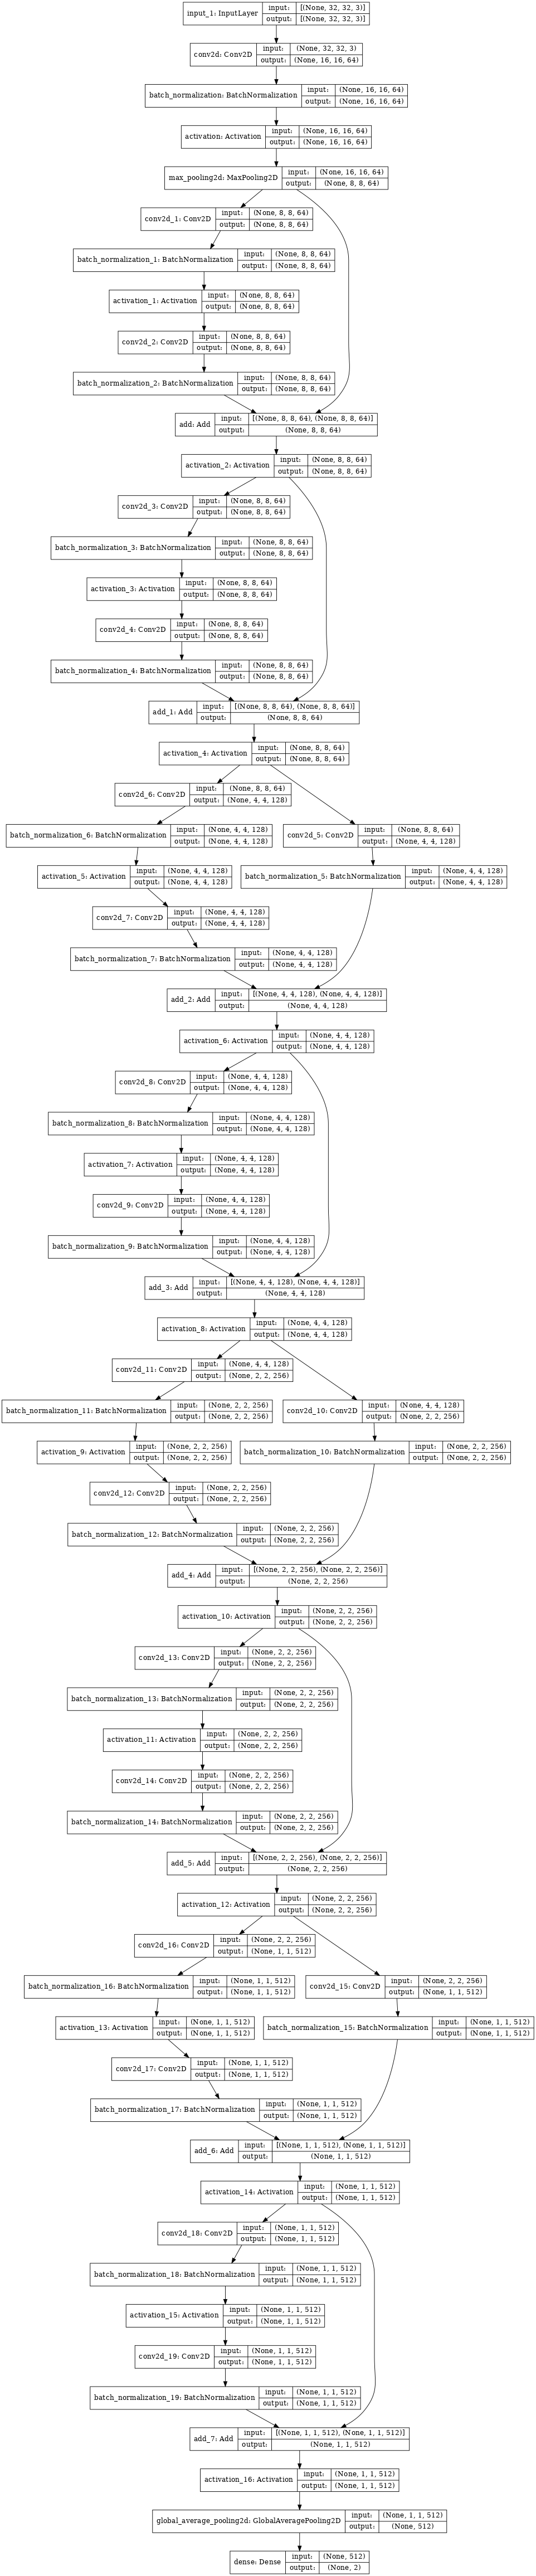

In [15]:
tf.keras.utils.plot_model(resnet_34, show_shapes=True, dpi=64)

#### ResNet-50

In [16]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True, is_skip_connection = True)
resnet_50.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 16, 16, 64)   256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 16, 16, 64)   0           batch_normalization_20[0][0]     
__________________________________________________________________________________________

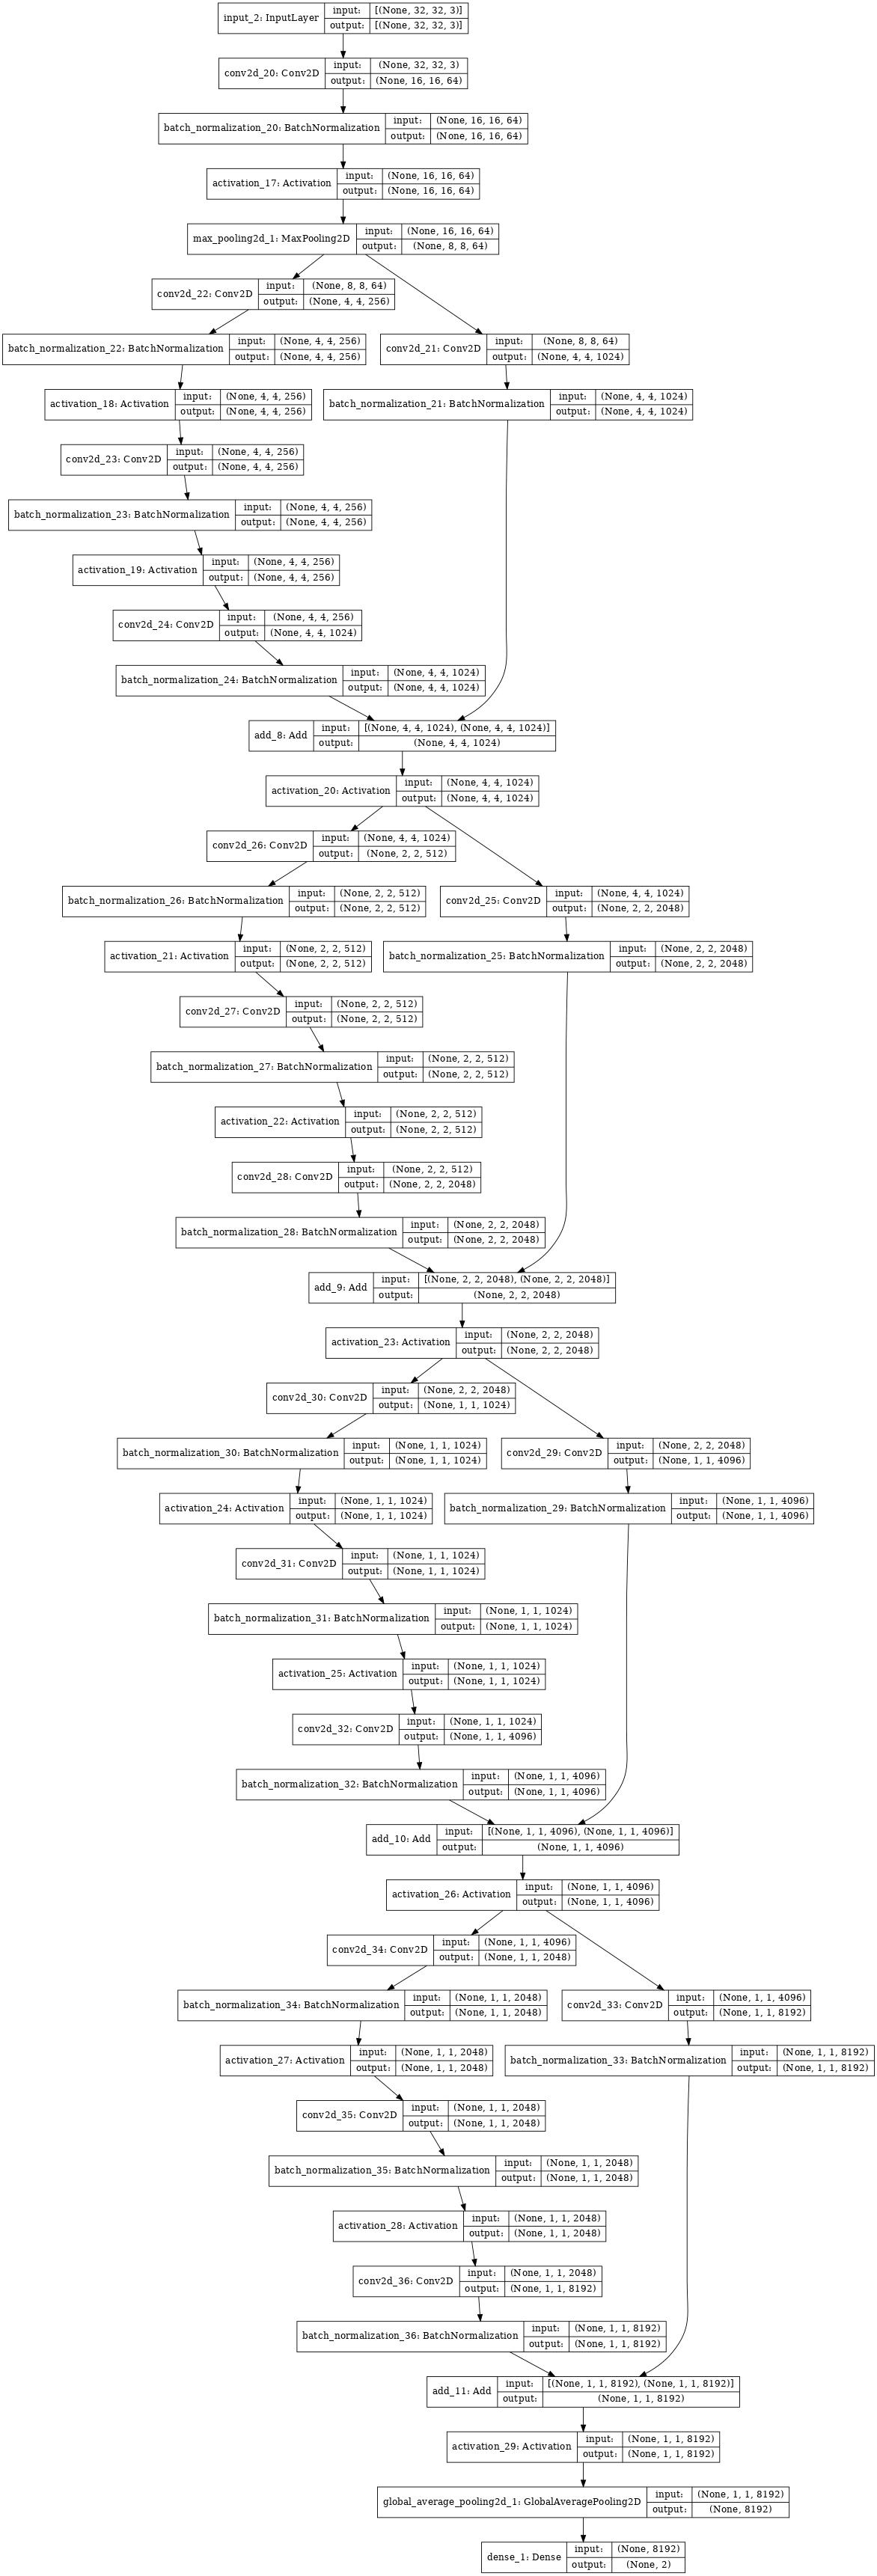

In [17]:
tf.keras.utils.plot_model(resnet_50, show_shapes=True, dpi=64)

## 3) 일반 네트워크(plain network) 만들기
#### Plain 34

In [18]:
plain_34 = build_resnet(input_shape=(32,32,3), is_50=False, is_skip_connection = False, name = 'Plain-34')
plain_34.summary()

Model: "Plain-34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_30 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_38 (Batc (None, 8, 8, 64)          256

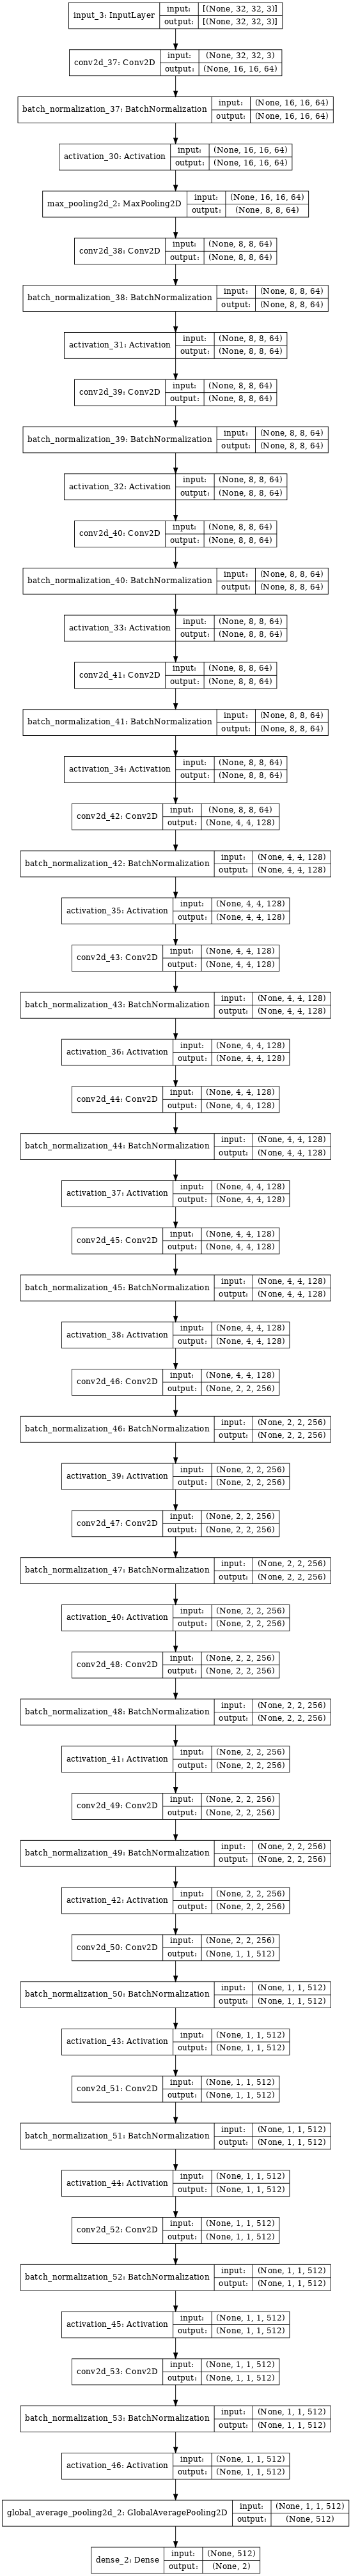

In [19]:
tf.keras.utils.plot_model(plain_34, show_shapes=True, dpi=64)

#### Plain 50

In [20]:
plain_50 = build_resnet(input_shape=(32,32,3), is_50 = True, is_skip_connection = False, name = 'Plain-50')
plain_50.summary()

Model: "Plain-50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_54 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_47 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 8, 8, 256)         16640     
_________________________________________________________________
batch_normalization_55 (Batc (None, 8, 8, 256)         102

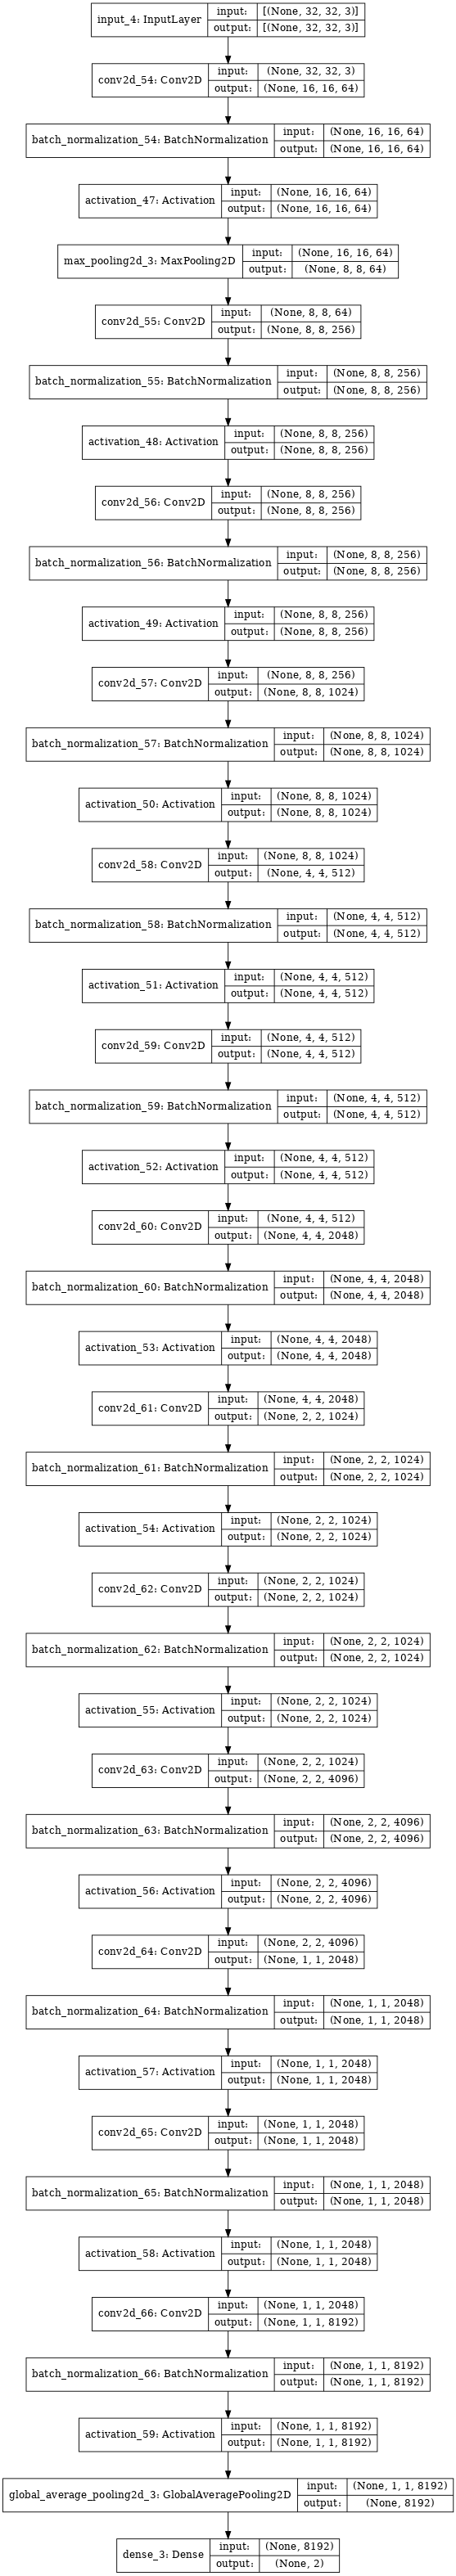

In [21]:
tf.keras.utils.plot_model(plain_50, show_shapes=True, dpi=64)

## 4) 모델 훈련

In [22]:
BATCH_SIZE = 32
EPOCH = 10

In [23]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    shuffle_files=True,
    as_supervised = True
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

#### ResNet 34

In [24]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         is_skip_connection=True,
                         activation='sigmoid', 
                         name='ResNet_34')

In [25]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 197s 297ms/step - loss: 1.5820 - accuracy: 0.5998 - val_loss: 1.2062 - val_accuracy: 0.5119
Epoch 2/10
581/581 [==============================] - 164s 282ms/step - loss: 0.8655 - accuracy: 0.7282 - val_loss: 0.9444 - val_accuracy: 0.5965
Epoch 3/10
581/581 [==============================] - 159s 274ms/step - loss: 0.6544 - accuracy: 0.7821 - val_loss: 0.9468 - val_accuracy: 0.6037
Epoch 4/10
581/581 [==============================] - 159s 274ms/step - loss: 0.5480 - accuracy: 0.8197 - val_loss: 0.5347 - val_accuracy: 0.8294
Epoch 5/10
581/581 [==============================] - 159s 274ms/step - loss: 0.4771 - accuracy: 0.8498 - val_loss: 0.7627 - val_accuracy: 0.6737
Epoch 6/10
581/581 [==============================] - 159s 274ms/step - loss: 0.4248 - accuracy: 0.8777 - val_loss: 0.5094 - val_accuracy: 0.8444
Epoch 7/10
581/581 [==============================] - 159s 274ms/step - loss: 0.3896 - accuracy: 0.8919 - val_loss: 0.5299 -

#### ResNet 50

In [26]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         is_skip_connection=True,
                         activation='sigmoid',
                         name = 'ResNet_50')

In [27]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 585s 964ms/step - loss: 6.4607 - accuracy: 0.5985 - val_loss: 2.0160 - val_accuracy: 0.6706
Epoch 2/10
581/581 [==============================] - 534s 920ms/step - loss: 1.6538 - accuracy: 0.6783 - val_loss: 1.0927 - val_accuracy: 0.6377
Epoch 3/10
581/581 [==============================] - 534s 920ms/step - loss: 0.9580 - accuracy: 0.7165 - val_loss: 0.8786 - val_accuracy: 0.6748
Epoch 4/10
581/581 [==============================] - 534s 919ms/step - loss: 0.7832 - accuracy: 0.7395 - val_loss: 0.8623 - val_accuracy: 0.6552
Epoch 5/10
581/581 [==============================] - 534s 920ms/step - loss: 0.7382 - accuracy: 0.7527 - val_loss: 1.3150 - val_accuracy: 0.5716
Epoch 6/10
581/581 [==============================] - 534s 920ms/step - loss: 0.7072 - accuracy: 0.7622 - val_loss: 1.2565 - val_accuracy: 0.5303
Epoch 7/10
581/581 [==============================] - 534s 920ms/step - loss: 0.6749 - accuracy: 0.7835 - val_loss: 0.9885 -

#### Plain 34

In [28]:
plain_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         is_skip_connection=False,
                         activation='sigmoid', 
                         name='Plain_34')

In [29]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 158s 258ms/step - loss: 1.3393 - accuracy: 0.5865 - val_loss: 31.4490 - val_accuracy: 0.5076
Epoch 2/10
581/581 [==============================] - 150s 257ms/step - loss: 0.8469 - accuracy: 0.5855 - val_loss: 1.7817 - val_accuracy: 0.5325
Epoch 3/10
581/581 [==============================] - 150s 257ms/step - loss: 0.7198 - accuracy: 0.6599 - val_loss: 4.2046 - val_accuracy: 0.5093
Epoch 4/10
581/581 [==============================] - 150s 258ms/step - loss: 0.6709 - accuracy: 0.6790 - val_loss: 1.2235 - val_accuracy: 0.5446
Epoch 5/10
581/581 [==============================] - 150s 258ms/step - loss: 0.6277 - accuracy: 0.7154 - val_loss: 1.2456 - val_accuracy: 0.4911
Epoch 6/10
581/581 [==============================] - 150s 257ms/step - loss: 0.5996 - accuracy: 0.7337 - val_loss: 1.4193 - val_accuracy: 0.5015
Epoch 7/10
581/581 [==============================] - 150s 258ms/step - loss: 0.5691 - accuracy: 0.7598 - val_loss: 0.5730 

#### Plain 50

In [30]:
plain_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True, 
                         is_skip_connection=False,
                         activation='sigmoid', 
                         name='Plain_50')

In [31]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
581/581 [==============================] - 851s 1s/step - loss: 3.6943 - accuracy: 0.5568 - val_loss: 1.1907 - val_accuracy: 0.5591
Epoch 2/10
581/581 [==============================] - 795s 1s/step - loss: 1.0254 - accuracy: 0.5739 - val_loss: 1.2647 - val_accuracy: 0.4723
Epoch 3/10
581/581 [==============================] - 795s 1s/step - loss: 0.8486 - accuracy: 0.5638 - val_loss: 0.8098 - val_accuracy: 0.6222
Epoch 4/10
581/581 [==============================] - 790s 1s/step - loss: 0.7869 - accuracy: 0.5959 - val_loss: 0.9779 - val_accuracy: 0.4918
Epoch 5/10
581/581 [==============================] - 790s 1s/step - loss: 0.7584 - accuracy: 0.6082 - val_loss: 0.8170 - val_accuracy: 0.5593
Epoch 6/10
581/581 [==============================] - 792s 1s/step - loss: 0.7711 - accuracy: 0.6194 - val_loss: 0.9212 - val_accuracy: 0.5762
Epoch 7/10
581/581 [==============================] - 790s 1s/step - loss: 0.7722 - accuracy: 0.6297 - val_loss: 0.8942 - val_accuracy: 0.4892

## 5) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

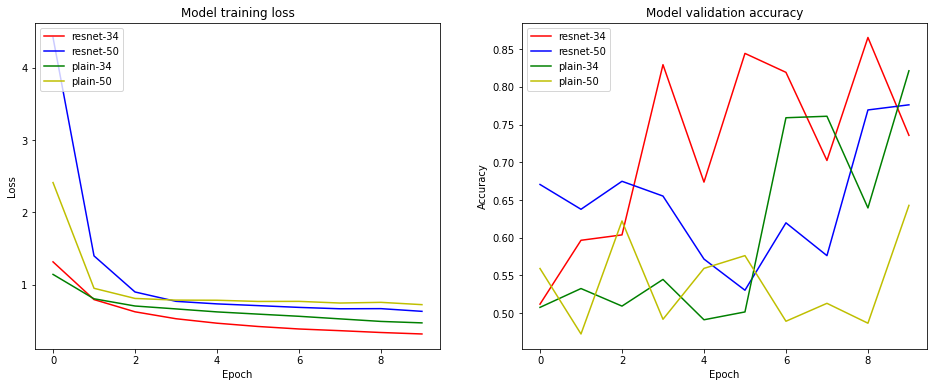

In [36]:
figure = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_34.history['loss'], 'g')
plt.plot(history_50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet-34', 'resnet-50', 'plain-34', 'plain-50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_34.history['val_accuracy'], 'g')
plt.plot(history_50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet-34', 'resnet-50', 'plain-34', 'plain-50'], loc='upper left')
plt.show()

#### Loss, Accuracy 분석

#### Loss
- GPU 메모리량 부족으로 batch 크기를 32로 작게 잡아주었으나, Loss값이 크게 튀지 않고 안정적으로 수렴하는 것으로 보아, batch 크기가 충분히 컸음을 알 수 있다. 그렇다면 왜 batch 크기를 늘려줘야 안정적으로 loss 값이 수렴할까? 보통 batch라는게 전체 dataset 중 batch 크기만큼 뽑아줘서 훈련을 시킨다는 의미인데, batch 크기가 크다면, 확률의 임의성이 줄어 loss값이 보다 더 완만하게 수렴하기 때문이다.
- 또한 가능하다면 batch 크기가 충분하더라도 늘려주는 것이 한꺼번에 처리하는 양을 늘려 연산 속도를 빠르게 해주기 때문에 항상 batch size를 최대한 크게 잡아주자. 
- Loss를 보면 layer가 적은 resnet 34와 plain 34가 loss 값이 적었다. 그에 반해, resnet 50과 plain 50은 loss 값이 컸다. 따라서, layer가 깊어질수록 loss가 커지는 것이라고 생각한다. Layer가 쌓일수록 복잡도가 올라가는 것과 관련있지 않을까 조심스럽게 추측해본다.
- 하지만 적은 layer모델이 loss가 적다고 해서 accuracy가 높아지는 것이 아니므로 주의하자.
- Resnet34의 loss < Plain34의 loss, Resent50의 loss < Plain50의 loss이므로 Resnet의 skip connection이 degradation 문제를 효과적으로 해결해서 loss 값이 낮아질 수 있도록 한 것을 확인할 수 있었다.

#### Accuracy
- Epoch의 수를 적게 잡아줘서 Epoch = 10까지밖에 못봐줘서 ResNet34와 Plain34의 정확도가 더 높았으나, Epoch가 높아지면 ResNet50과 Plain50의 정확도가 더 높아질 것으로 예측한다. 그렇게 생각한 이유는 34 layer 모델과 50 layer 모델의 learning rate를 동일하게 잡아준 상태로 epoch 수를 충분히 크지 않게 잡아줬기 때문이다. 다시 말해서, 모델의 층수가 적어서 복잡도가 적으면 동일한 learning rate일 때 학습이 최대치로 진행되는 속도가 빠를 것이다. 그에 반해, 모델의 층수가 많아져서 복잡도가 커지면 동일한 learning rate일 때 학습이 느리게 진행된다.
- 정리하자면, 물론 layer가 적으면 초반의 정확도가 빨리 상승할 것이나, layer가 많으면 초반의 정확도가 가파르게 상승하진 않겠지만, 천천히 더 오래 Epoch를 늘려줘서 학습을 충분히 시켜주면 정확도가 최종적으로 더 높아질 것으로 예상된다.
- Resnet34의 accuracy > Plain34의 accuracy, Resent50의 accuracy < Plain50의 accuracy이므로, 동일한 layer 수 내에서, ResNet의 skip connection이 degradation 문제를 해결함으로써 accuracy가 높아진 것을 확인하였다.

#### 회고
- ResNet은 잘 알려진 모델이고 인터넷을 검색하면 keras나 pytorch를 사용해서 짜여진 코드들이 굉장히 많다.
- 그러나, 이번 고잉디퍼의 목적은 layer 하나하나를 직접 써주기보단, 반복되는 블록들을 만들어줘서 이를 쌓는 것을 목표였다.
- 따라서, 34 layer vs 50 layer, skip_connection 여부라는 두 가지 기준으로 나누어서 4가지 경우의 수가 있는 블록 함수를 만들어줬다.
- 모델 생성 함수 역시 4가지 경우의 수로 나누어 작성하였다.
- 그럼으로써 모델을 함수를 불러와 한줄로 작성할 수 있었다.
- 커널이 계속 튕겨서 많은 epoch를 돌려보지 못해서 아쉬운 점이 많았다.
- 하지만 layer를 논문을 보고 쌓으려고 노력하는 과정에서 모델 자체에 대한 이해도가 높아졌다.